In [49]:
import requests
import pandas as pd
import plotly.express as px

In [2]:
base_url = "https://api.microbiomedata.org"
filt = "title.search:Bio-Scales"
url = f"{base_url}/studies?filter={filt}"
resp = requests.get(url)
studies = resp.json()["results"]
study_ids = []
for study in studies:
    study_ids.append(study["id"])
# Since there is only one value in the results, convert list to a string
study = "".join(study_ids)
print(study)

nmdc:sty-11-r2h77870


In [40]:
per_page = 2000
fields = "ph,calcium,magnesium,potassium,tot_nitro,manganese,zinc,ammonium_nitrogen,nitrate_nitrogen,nitrite_nitrogen,ecosystem_subtype,habitat"
filt = f"part_of:{study}"
cursor = "*"
all_results = []

# Use cursor pagination to get results
while True:
    url = f"{base_url}/biosamples?&filter={filt}&per_page={per_page}&cursor={cursor}&fields={fields}"
    resp = requests.get(url)
    data = resp.json()
    results = data["results"]
    cursor = data["meta"]["next_cursor"]
    all_results.extend(results)
    if not cursor:
        break

print(f"Total number of biosamples: {len(all_results)}")
print(all_results[0])

Total number of biosamples: 416
{'id': 'nmdc:bsm-11-011z7z70', 'ecosystem_subtype': 'Rhizosphere', 'habitat': 'Rhizosphere soil'}


In [42]:
# How many biosamples include the requested fields?
# 103 of the 416 returned biosamples appear to have the fields we need for analysis

# convert string of fields from request above to dictionary with values set to 0
fields_list = fields.split(',')
field_counts = {field: 0 for field in fields_list}

for field in field_counts.keys():
    for samp in all_results:
        if field in samp:
            field_counts[field] += 1
            
print(field_counts)

{'ph': 103, 'calcium': 103, 'magnesium': 103, 'potassium': 103, 'tot_nitro': 103, 'manganese': 103, 'zinc': 103, 'ammonium_nitrogen': 103, 'nitrate_nitrogen': 103, 'nitrite_nitrogen': 103, 'ecosystem_subtype': 416, 'habitat': 416}


In [44]:
# Drop all rows that do not include all of the data we need and print

filtered_results = [biosamp for biosamp in all_results if all(field in biosamp for field in fields_list)]
print(filtered_results)

[{'id': 'nmdc:bsm-11-01teww33', 'ecosystem_subtype': 'Botanical garden', 'habitat': 'Soil', 'ph': 6.81, 'calcium': {'has_raw_value': '2320.83 mg/kg', 'has_numeric_value': 2320.83, 'has_unit': 'mg/kg'}, 'magnesium': {'has_raw_value': '458.94 mg/kg', 'has_numeric_value': 458.94, 'has_unit': 'mg/kg'}, 'potassium': {'has_raw_value': '489.767 mg/kg', 'has_numeric_value': 489.767, 'has_unit': 'mg/kg'}, 'tot_nitro': {'has_raw_value': '0.326 Percent', 'has_numeric_value': 0.326, 'has_unit': 'Percent'}, 'manganese': {'has_raw_value': '20.1285 mg/kg', 'has_numeric_value': 20.1285, 'has_unit': 'mg/kg'}, 'zinc': {'has_raw_value': '2.638 mg/kg', 'has_numeric_value': 2.638, 'has_unit': 'mg/kg'}, 'ammonium_nitrogen': {'has_raw_value': '2.329 mg/kg', 'has_numeric_value': 2.329, 'has_unit': 'mg/kg'}, 'nitrate_nitrogen': {'has_raw_value': '2.804 mg/kg', 'has_numeric_value': 2.804, 'has_unit': 'mg/kg'}, 'nitrite_nitrogen': {'has_raw_value': '0 mg/kg', 'has_numeric_value': 0.0, 'has_unit': 'mg/kg'}}, {'id

In [46]:
# Convert results to desired types and transform to data frame
# collect units for applicable fields
    
# Make list of all fields with "has_raw_value" sub-field and remove the rest
other_fields = ["ecosystem_subtype", "habitat", "id", "ph"]
raw_value_fields = list(filter(lambda field: field not in remove_fields, fields_list))

# create dictionary of raw_value_fields with values as empty lists
units = {field: [] for field in raw_value_fields}

# Add filtered results to a new list of dictionaries with desired data types, extract out units into a separate dictionary 
df_inp = []
for biosamp in filtered_results:
    rec = {}
    for field in raw_value_fields:
        rec[field] = float(biosamp[field]["has_numeric_value"])
        units[field].append(biosamp[field]["has_unit"])
    for other_field in other_fields:
        if other_field == "ph":
            rec[other_field] = float(biosamp[other_field])
        else:
            rec[other_field] = biosamp[other_field]
    df_inp.append(rec)

# Convert list of results dictionaries to a data frame
df = pd.DataFrame(df_inp)

df 

,calcium,magnesium,potassium,tot_nitro,manganese,zinc,ammonium_nitrogen,nitrate_nitrogen,nitrite_nitrogen,ecosystem_subtype,habitat,id,ph
0,2320.83,458.940,489.7670,0.326,20.1285,2.6380,2.3290,2.8040,0.0,Botanical garden,Soil,nmdc:bsm-11-01teww33,6.81
1,1945.98,351.875,304.9650,0.242,17.6880,2.6576,1.8015,1.6980,0.0,Botanical garden,Soil,nmdc:bsm-11-08mamh62,6.64
2,1963.54,399.987,181.0690,0.342,28.8914,5.5845,10.6770,18.1475,0.0,Botanical garden,Soil,nmdc:bsm-11-0pp1y564,5.07
3,2217.89,439.551,153.6870,0.232,20.3547,1.8725,2.4445,1.9190,0.0,Botanical garden,Soil,nmdc:bsm-11-1dpnqj50,6.63
4,2406.67,392.849,121.6290,0.544,36.8924,7.3694,18.6560,9.2710,0.0,Botanical garden,Soil,nmdc:bsm-11-1eybv881,5.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2431.98,509.653,138.7240,0.151,32.3007,2.8379,4.4525,0.4225,0.0,Botanical garden,Soil,nmdc:bsm-11-ynkz2756,6.48
99,2093.64,374.933,69.5327,0.565,37.4526,6.1641,14.0600,13.3625,0.0,Botanical garden,Soil,nmdc:bsm-11-yqjjes90,4.96
100,2351.52,445.767,289.8160,0.393,26.6471,3.8888,3.2260,2.1155,0.0,Botanical garden,Soil,nmdc:bsm-11-yqrv3r15,6.59
101,1673.10,331.686,146.7840,0.063,10.6006,2.0413,1.6160,0.8630,0.0,Botanical garden,Soil,nmdc:bsm-11-z423gx54,6.78


In [39]:
# Convert unit dictionary lists to set to remove redundant units
units = {field: set(unit_list) for field, unit_list in units.items()}
print(f"Units for each applicable measurement: {units}")

Units for each applicable measurement: {'calcium': {'mg/kg'}, 'magnesium': {'mg/kg'}, 'potassium': {'mg/kg'}, 'tot_nitro': {'Percent'}, 'manganese': {'mg/kg'}, 'zinc': {'mg/kg'}, 'ammonium_nitrogen': {'mg/kg'}, 'nitrate_nitrogen': {'mg/kg'}, 'nitrite_nitrogen': {'mg/kg'}}


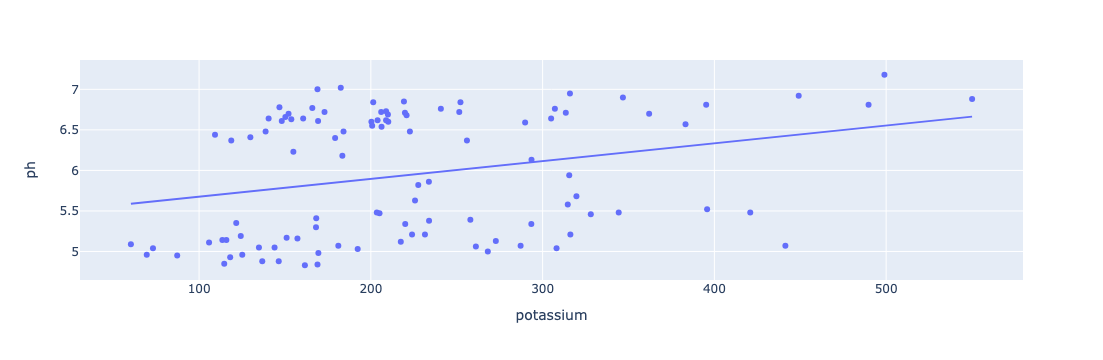

In [67]:
# Look at potassium vs. ph
fig = px.scatter(df, x="potassium", y="ph", trendline = "ols")
fig.show()

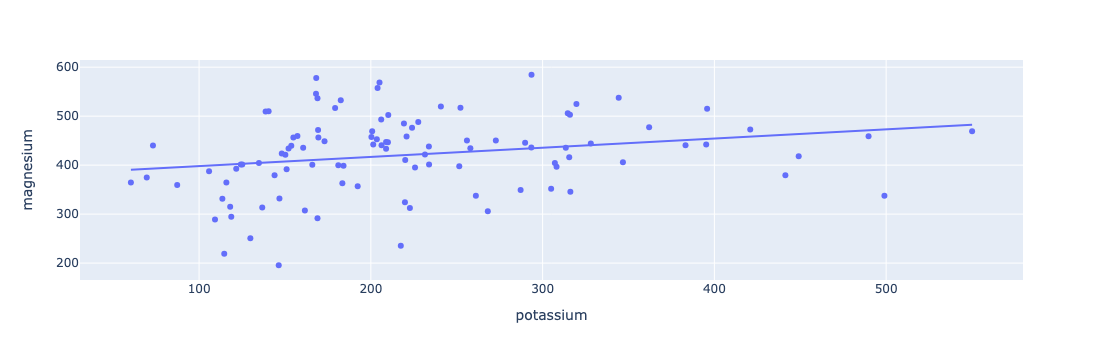

In [72]:
fig = px.scatter(df, x="potassium", y="magnesium", trendline = "ols")
fig.show()

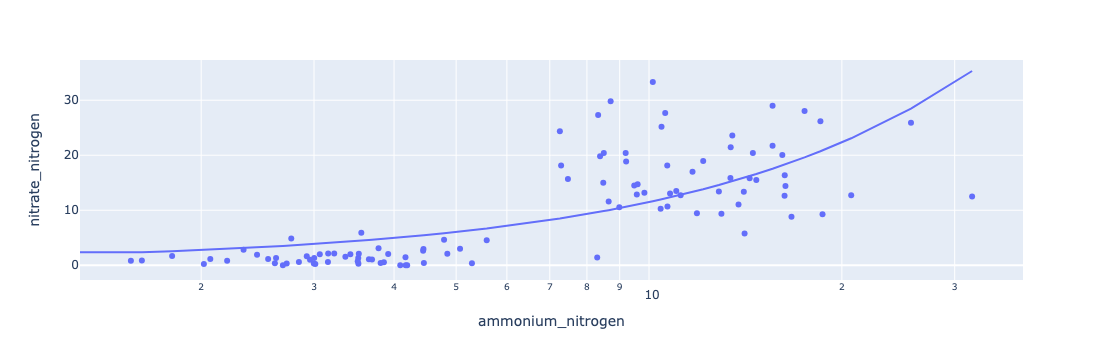

In [77]:
fig = px.scatter(df, x="ammonium_nitrogen", y="nitrate_nitrogen", trendline = "ols", log_x=True)
fig.show()